In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
from strategies_and_optimisation import gen_daily_sharpe, custom_grid_search, momentum_strat, mean_reversion, post_div_drift, SMAC, EMAC

In [2]:
# Import and organise dataframe
df = pd.read_csv('Q32019_present.csv')
df['Date'] = pd.to_datetime(df['Date'])

start_date = df['Date'].min()
end_date = df['Date'].max()

df.set_index(['Date', 'PlayerName'], inplace=True)
df.sort_index(level=0, inplace=True)

# Calculate log returns variables
df['daily_log_returns'] = df['EndofDayPrice'].apply(np.log).groupby(level=1).diff(1)
df['daily_mkt_log_returns'] = df['ave_mkt_price'].apply(np.log).groupby(level=1).diff(1) 

first_day = df.loc[(start_date, slice(None)), :]
top200_mask = first_day.nlargest(200, 'EndofDayPrice').index.droplevel(0).values
top200_full = df.loc[(slice(None), top200_mask), :]

# Seperate train and test sets
top200 = df.loc[:'2020-07-01', :]
out_of_sample = df.loc['2020-07-01':, :]

In [3]:
# Set plot style
style.use('fivethirtyeight')

# Initial exploratory plots. 
We will consider FIE top200 index against the SP500 (SPY). Lack of market beta is really sick.

Text(0.5, 1.0, 'Cumulative index returns')

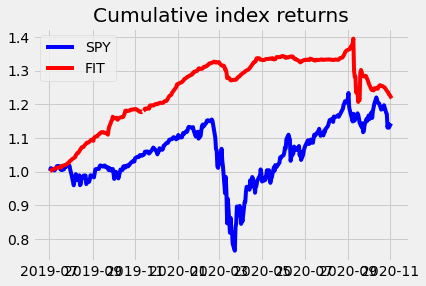

In [4]:
# Comparing to SP500
SPY = yf.Ticker('SPY')
SPY_history = SPY.history(start=start_date, end=end_date)['Close'] # Care dont overuse, works on yahoo scraping.
SPY_log_returns = SPY_history.apply(np.log).diff(1)
SPY_cum_returns = SPY_log_returns.cumsum().apply(np.exp)

# Extract index price
index_price = df.groupby(level=0)['ave_mkt_price'].head(1).values
# Football index tracker fund (FIT) (comprising of top200)
FIT_log_returns = df['daily_mkt_log_returns'].groupby(level=0).head(1).droplevel(1)
FIT_cum_returns = FIT_log_returns.cumsum().apply(np.exp)

# Plot cumulative returns
fig, ax = plt.subplots()
ax.plot(SPY_cum_returns.index, SPY_cum_returns, color='b', label='SPY')
ax.plot(FIT_cum_returns.index, FIT_cum_returns, color='r', label='FIT')
ax.legend()
ax.set_title('Cumulative index returns')

Now consider Sharpe ratios for the 2 instruments...

SPY annualised Sharpe ratio: 0.030687074260840563
FIT annualised Sharpe ratio: 0.07905521839801927


Text(0.5, 1.0, 'Daily index returns')

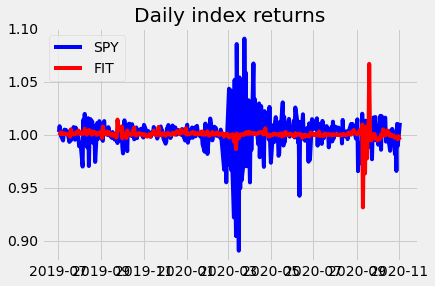

In [22]:
# Benchmark Sharpe ratios

# First generate daily returns
SPY_daily_returns = SPY_log_returns.apply(np.exp)
FIT_daily_returns = FIT_log_returns.apply(np.exp)

SPY_sharpe = gen_daily_sharpe(SPY_daily_returns)
print('SPY annualised Sharpe ratio: ' + str(SPY_sharpe))
    
FIT_sharpe = gen_daily_sharpe(FIT_daily_returns)
print('FIT annualised Sharpe ratio: ' + str(FIT_sharpe))


# NOTE/ YOU X THESE BY ROOT(TRADING DAYS), 
# SO JUST ALL DAYS SINCE FI IS A 365-DAY MARKET. You're counting returns across all those days. 
# If you're not mean'ing across sat-sun in SP500 calcs, then dont over multiply when you annualise the sharpes.
# It would be a fairer comparison if you had a year's data for both.

# Plot cumulative returns
fig, ax = plt.subplots()
ax.plot(SPY_daily_returns.index, SPY_daily_returns, color='b', label='SPY')
ax.plot(FIT_daily_returns.index, FIT_daily_returns, color='r', label='FIT')
ax.legend()
ax.set_title('Daily index returns')

In [23]:
temp = pd.DataFrame(SPY_daily_returns).join(FIT_daily_returns, how='inner').dropna()
corr_matrix = np.corrcoef(temp.iloc[:,0], temp.iloc[:,1])
print('Daily returns corr coefficient: ' + str(corr_matrix[1,0]))

Daily returns corr coefficient: 0.12969296634735483


Distribution of returns is decently tight...
As always fat tails come into play. TODO: Make these tail datapoints visible

C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\micha\anaconda3\envs\football_index\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


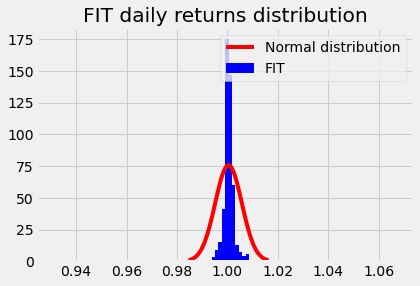

In [40]:
# KDE plots (kind of too many plots but whatever...)
fig, ax = plt.subplots()
ax.hist(FIT_daily_returns, bins=100, label='FIT', color='b')

mu = FIT_daily_returns.mean()
sigma = FIT_daily_returns.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
ax.plot(x, norm.pdf(x, mu, sigma), label='Normal distribution', color='r')

ax.set_title('FIT daily returns distribution')
ax.legend();

Considering mkt beta dispersion in FI

Player stock betas are generally centered very close to 0. While returns across the board have an upward bias across the sample, individual player stocks move fairly independently, with high market betas probably being driven by random chance more than other factors. 

Text(0.5, 1.0, 'Distribution of player stock betas')

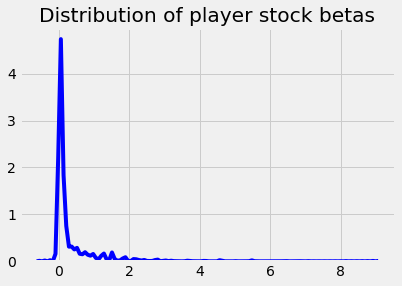

In [37]:
# Gen cov matrix and slice off the useful values
cov = df.groupby(level=1)[['daily_returns', 'daily_mkt_returns']].cov()
cov = cov.loc[(slice(None), 'daily_mkt_returns'), 'daily_returns']

cov.index = cov.index.droplevel(1)
mkt_beta = cov / (df.groupby(level=1)['daily_returns'].std() ** 2)

# PLOT: Market beta dispersion
fig, ax = plt.subplots()
sns.kdeplot(mkt_beta.dropna(), ax=ax, legend=False, color='b')
ax.set_title('Distribution of player stock betas')

We also consider, given FI is an immature market, pricing affectations may well occur predictably on days of the week. (Drawing on inspiration from Gibbons and Hess (1981) https://www.jstor.org/stable/2352725) 

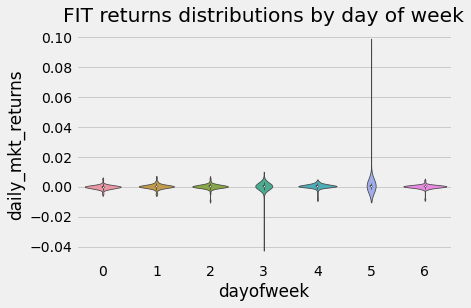

In [46]:
# Consider Business day effects on FI...
df['dayofweek'] = df.index.get_level_values(0)
df['dayofweek'] = df['dayofweek'].dt.weekday

# Extract day of week from index
mkt_returns = df.groupby(level=0)[['daily_mkt_returns', 'dayofweek']].head(1)
mkt_returns.index = mkt_returns.index.droplevel(level=1)

# PLOT: Day of week trends
fig, ax = plt.subplots()
ax.set_title('FIT returns distributions by day of week')
sns.violinplot(x="dayofweek", y='daily_mkt_returns', data=mkt_returns, linewidth=0.8, ax=ax);

## Scouting basic quant strategy
Note we only consider the following strategies among the highest priced 200 players. FI is already an extremely illiquid market even without considering those at the lower end of the market. Slippage and trading costs will regardless hit these strategies fairly hard, so for relevance we only consider trading the top 200. 

STRATEGY 1: Price Momentum
Players are placed in a long-only portfolio if their daily returns across the lookback period are among the top 15 highest. 
(Carhart, 1997 https://doi.org/10.1111/j.1540-6261.1997.tb03808.x)

In [47]:
# STRATEGY 1: Price momentum
data = top200
strategy = momentum_strat
param_grid = {'lookback_window': [3, 7, 14, 21],
              'holding_period': [3, 7, 14, 21]}

results, optimal_params = custom_grid_search(data, strategy, param_grid)
print(results)

results = momentum_strat(data, param_dict=optimal_params)
results.plot(title='Momentum strategy cumulative returns')

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

C:\Users\micha\Documents\Quant\football_index\strategies_and_optimisation.py:70: RuntimeWarning: invalid value encountered in greater_equal
  portfolio_df[portfolio_df.values >= cutoff.values.reshape(len(cutoff),1)] = 1
C:\Users\micha\Documents\Quant\football_index\strategies_and_optimisation.py:71: RuntimeWarning: invalid value encountered in less
  portfolio_df[portfolio_df.values < cutoff.values.reshape(len(cutoff),1)] = 0


KeyboardInterrupt: 

Sharpe >< FIT???

STRATEGY 2: Mean reversion (Get rid?)
Mean reversion in stock prices: Evidence and Implications (1988) https://doi.org/10.1016/0304-405X(88)90021-9

In [ ]:
# STRATEGY 2: Mean reversion
# Find biggest losers in past x period, and long them. # This is a bad strat but holding periods tell us something???
data = top200
strategy = mean_reversion
param_grid = {'lookback_window': [3, 7, 14, 21],
              'holding_period': [3, 7, 14, 21]}

results, optimal = custom_grid_search(data, strategy, param_grid)
print(results)

results = mean_reversion(data, param_dict=optimal_params)
results = momentum_strat(data, param_dict=optimal_params)
results.plot(title='Momentum strategy cumulative returns') # TODO: Get params returning sharpe, then vis results

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

STRATEGY 3: Post div. drift
Consider buying players after a dividend is issued.
(Bernard and Thomas (1989), https://doi.org/10.2307/2491062)

In [ ]:
# STRATEGY 3: Post div. drift
data = top200
strategy = post_div_drift
param_grid = {'holding_period': [3, 6, 13, 20]}

results, optimal = custom_grid_search(data, strategy, param_grid)
print(results)

results = post_div_drift(data, param_dict=optimal_params)
results.plot(title='Post dividend drift strategy cumulative returns')

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

STRATEGY 4.1: SMAC

The SMA cross strategy is another pseudo-momentum following strategy. We buy when the moving averages cross over one another. Indicating a trend in one direction, and sell when they cross back. 

In [ ]:
# STRATEGY 4.1: SMAC (single player)
data = top200.loc[(slice(None),'Mohamed Salah'), 'EndofDayPrice'].unstack()
strategy = SMAC
param_grid = {'duration_MA1': [5, 22],
              'duration_MA2': [5, 22]}

results, optimal_params = custom_grid_search(data, strategy, param_grid)


results = SMAC(data, param_dict=optimal_params)
results.plot(title='SMAC cumulative returns')


daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

STRATEGY 4.2: EMAC

The EMA cross strategy is near identical to the SMA cross, but is done using exponentially weighted moving averages.

In [ ]:
# STRATEGY 4.2: EMAC
data = top200.loc[(slice(None),'Mohamed Salah'), 'EndofDayPrice'].unstack()
strategy = EMAC
param_grid = {'duration_EMA1': [3, 5, 7, 10, 15, 20],
              'duration_EMA2': [5, 7, 10, 15, 20, 25, 30]}

results, optimal_params = custom_grid_search(data, strategy, param_grid)


results = EMAC(data, param_dict=optimal_params)
results.plot(title='EMAC cumulative returns')


daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

### Out of sample testing the most effective strategies

In [ ]:
# STRATEGY 1: Price momentum
data = out_of_sample
strategy = momentum_strat

optimal_params =  {'holding_period': 7,
                   'lookback_window': 7}
# TODO: Get grid_search returning optimal params to chuck in. (then only run optimals in the final thing.)
results = momentum_strat(data, param_dict=optimal_params)
results.plot(title='Momentum strategy cumulative returns') # TODO: Get params returning sharpe, then vis results

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

In [ ]:
# STRATEGY 3: Post div. drift
data = top200
strategy = post_div_drift
param_grid = {'holding_period': [3, 6, 13, 20]}

#results = custom_grid_search(data, strategy, param_grid)
print(results)

optimal_params =  {'holding_period': 20}

results = post_div_drift(data, param_dict=optimal_params)
results.plot(title='Post dividend drift strategy cumulative returns')

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

In [ ]:
# STRATEGY 4.2: EMAC
data = out_of_sample.loc[(slice(None),'Mohamed Salah'), 'EndofDayPrice'].unstack()
strategy = EMAC

optimal_params = {'duration_EMA1': 3, 'duration_EMA2': 7}

results = EMAC(data, param_dict=optimal_params)
results.plot(title='EMAC cumulative returns')

daily_pf_returns = results.pct_change(1) + 1
strategy_sharpe = gen_daily_sharpe(daily_pf_returns)
print('Strategy daily Sharpe: ' + str(strategy_sharpe))

Top out-of-sample sharpe is...

In conclusion none of these are really winners due to massive trading costs. A 10% dock for trading costs and spread in the market (conservative estimate on the low end), takes all the above strategies into the red. 


The next best thing is then a buy and hold strategy.
This could be a reasonable strategy, but is hard to tell with the massive reversion just seen.
Additionally, sample size is very small. 
(say this at the top, don't waste time). 
The problem is that structural breaks are huge, a buy and HODL is essentially just like buying a proxy for football index stock itself.
The market is immature. Therefore things like this will happen. 
If you think that the market has a long run future, or will gain in popularity, you should buy in and hold through the likely future moments of extreme volatlility in the market. If you do not, trying to play for value with players using a systematic approach is probably a waste of time. 